# **Long Short-Term Memory Heat Flux Prediction Model**

In [131]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import sys

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from sklearn.model_selection import GroupKFold
from utils.lstm_utils import *

## Data loading

We load the train and test CSV files and irrelevant recordings).  
Our targets are two continuous heat flux signals: **back_flux** and **thigh_flux**.  

In [141]:
base_path = "/content/drive/MyDrive/ICE-human-heatflux-project"

data_training     = pd.read_csv(f"{base_path}/Train_without_FE.csv")
data_test         = pd.read_csv(f"{base_path}/Test_without_FE.csv")
data_training_FE  = pd.read_csv(f"{base_path}/Train_final.csv")
data_test_FE      = pd.read_csv(f"{base_path}/Test_final.csv")

data_training    = data_training[data_training["Session"] != 0].reset_index(drop=True)
data_test        = data_test[data_test["Session"] != 0].reset_index(drop=True)
data_training_FE = data_training_FE[data_training_FE["Session"] != 0].reset_index(drop=True)
data_test_FE     = data_test_FE[data_test_FE["Session"] != 0].reset_index(drop=True)

target_cols = ["back_flux", "thigh_flux"]
X_test = data_test.copy()
X_test_FE = data_test_FE.copy()

if all(c in X_test.columns for c in target_cols):
    y_test = X_test[target_cols].copy()
    X_test = X_test.drop(columns=target_cols, errors="ignore")
else:
    raise ValueError(
        "Test_without_FE.csv ne contient pas back_flux/thigh_flux -> "
        "impossible de calculer MAE/corr et ta fonction predict_and_plot exige y_test."
    )

if all(c in X_test_FE.columns for c in target_cols):
    y_test_FE = X_test_FE[target_cols].copy()
    X_test_FE = X_test_FE.drop(columns=target_cols, errors="ignore")
else:
    raise ValueError(
        "Test_final.csv ne contient pas back_flux/thigh_flux -> "
        "impossible de calculer MAE/corr sur le test FE."
    )

## Cross-validation (participant-level)

We evaluate each hyperparameter configuration with **5-fold GroupKFold**, where each fold holds out entire participants, to avoid data leakage across participants.

In [142]:
groups = data_training["participant_id"].values
gkf = GroupKFold(n_splits=5)

## Sequence dataset

For each `(participant_id, Session)`, we sort samples by time and build sliding windows of length `window`.  
Each training example uses the past `window` timesteps to predict the target at the next timestep (`t + window`).  
Windows never cross session boundaries, preventing temporal leakage between separate sessions.


In [143]:
class LSTMDataset(torch.utils.data.Dataset):
    def __init__(self, X_df, y_df, target_cols, window=5):
        self.target_cols = target_cols
        self.window = window
        self.data = {}   # (pid, sess) -> (X_tensor, y_tensor)
        self.index = []  # liste de (pid, sess, i)

        for (pid, sess), grp in X_df.groupby(["participant_id", "Session"]):
            grp = grp.sort_values("Time")
            y_grp = y_df.loc[grp.index]

            X_np = grp.drop(columns=["participant_id", "Time", "Session"], errors="ignore").to_numpy()
            y_np = y_grp[self.target_cols].to_numpy()

            if len(X_np) <= window:
                continue

            key = (pid, sess)
            self.data[key] = (
                torch.tensor(X_np, dtype=torch.float32),
                torch.tensor(y_np, dtype=torch.float32),
            )

            for i in range(len(X_np) - window):
                self.index.append((pid, sess, i))

        if len(self.index) == 0:
            raise ValueError("Aucune séquence créée. Vérifie window et la longueur des séries.")

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        pid, sess, i = self.index[idx]
        X_t, y_t = self.data[(pid, sess)]
        X = X_t[i:i + self.window]
        y = y_t[i + self.window]
        return X, y

## Model

We use a multi-output LSTM regressor to predict **[back_flux, thigh_flux]** jointly from the input sequence.  
The last hidden state summarizes the window, then two fully-connected layers map it to the 2 outputs.


In [144]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, fc_dim=8, output_dim=2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            dropout=0.2,
            batch_first=True
        )
        self.fc1 = nn.Linear(hidden_dim, fc_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_dim, output_dim)

        # (si tu l'avais au training, on le garde)
        self.log_sigma = nn.Parameter(torch.zeros(2))

    def forward(self, x):
        out, (h_n, c_n) = self.lstm(x)
        last_hidden = h_n[-1]  # (batch, hidden_dim)
        x = self.fc1(last_hidden)
        x = self.relu(x)
        x = self.fc2(x)  # (batch, 2)
        return x

## Results without historical features using the loaded model

In [146]:
bundle = load_lstm_bundle(
    "/content/drive/MyDrive/best_lstm_bundle_lstm_vFINAL.pth",
    LSTMRegressorClass=LSTMRegressor,
)

X_test_scaled, X_test_aligned = align_and_scale_X_test(
    X_test,
    num_cols=bundle["num_cols"],
    scaler=bundle["scaler"],
)

model  = bundle["model"]
device = bundle["device"]
window = bundle["window"]
num_cols = bundle["num_cols"]

Loaded model from bundle.
window = 40 | hidden_dim = 64 | n_features = 14


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


## Inference and visualization

We rebuild the exact feature order used during training, apply the saved scaler, then generate predictions.  
For plotting, we split sessions based on time gaps (`gap_minutes`). Optionally, we compress gaps so the curve is continuous.

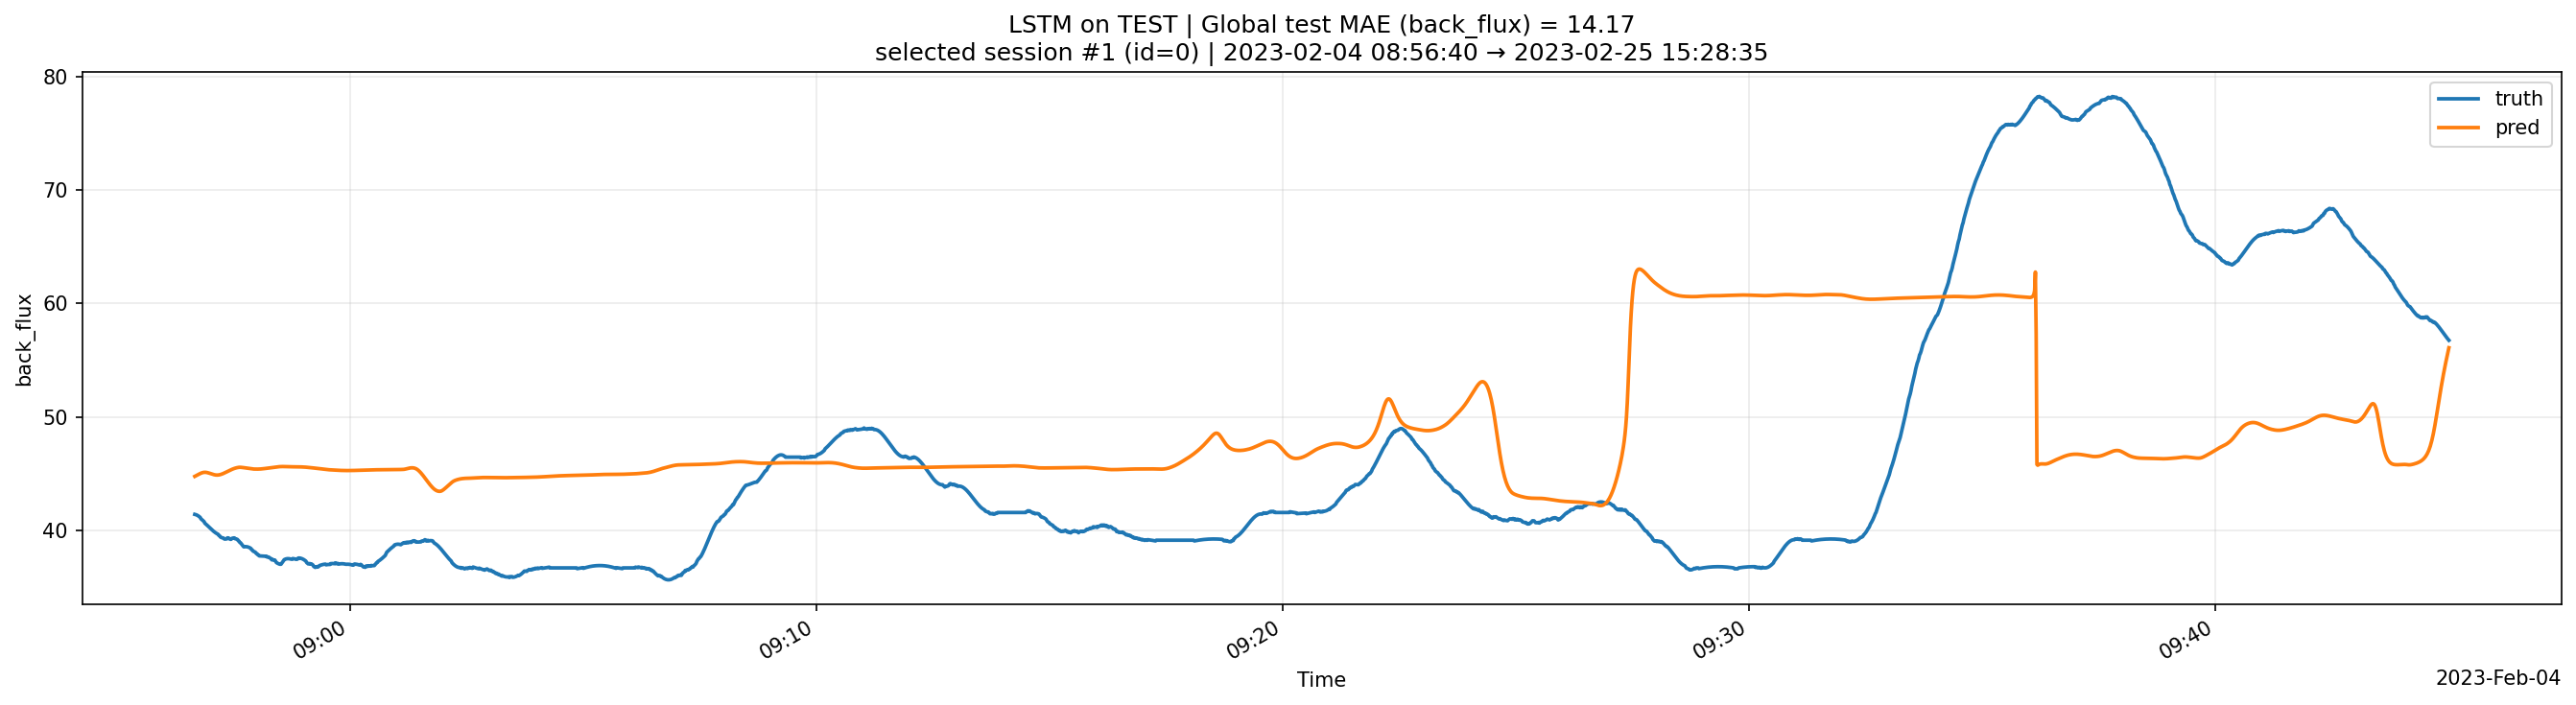

In [147]:
pred_df_test = predict_and_plot(
    model=model,
    X_test=X_test_scaled,
    y_test=y_test,
    participant_id="F7",
    mode="selected",
    session_number=1,
    gap_minutes=60,
    compress_gaps=True,
    window=window,
    target="back_flux",
    title="LSTM on TEST",
    device=device
)

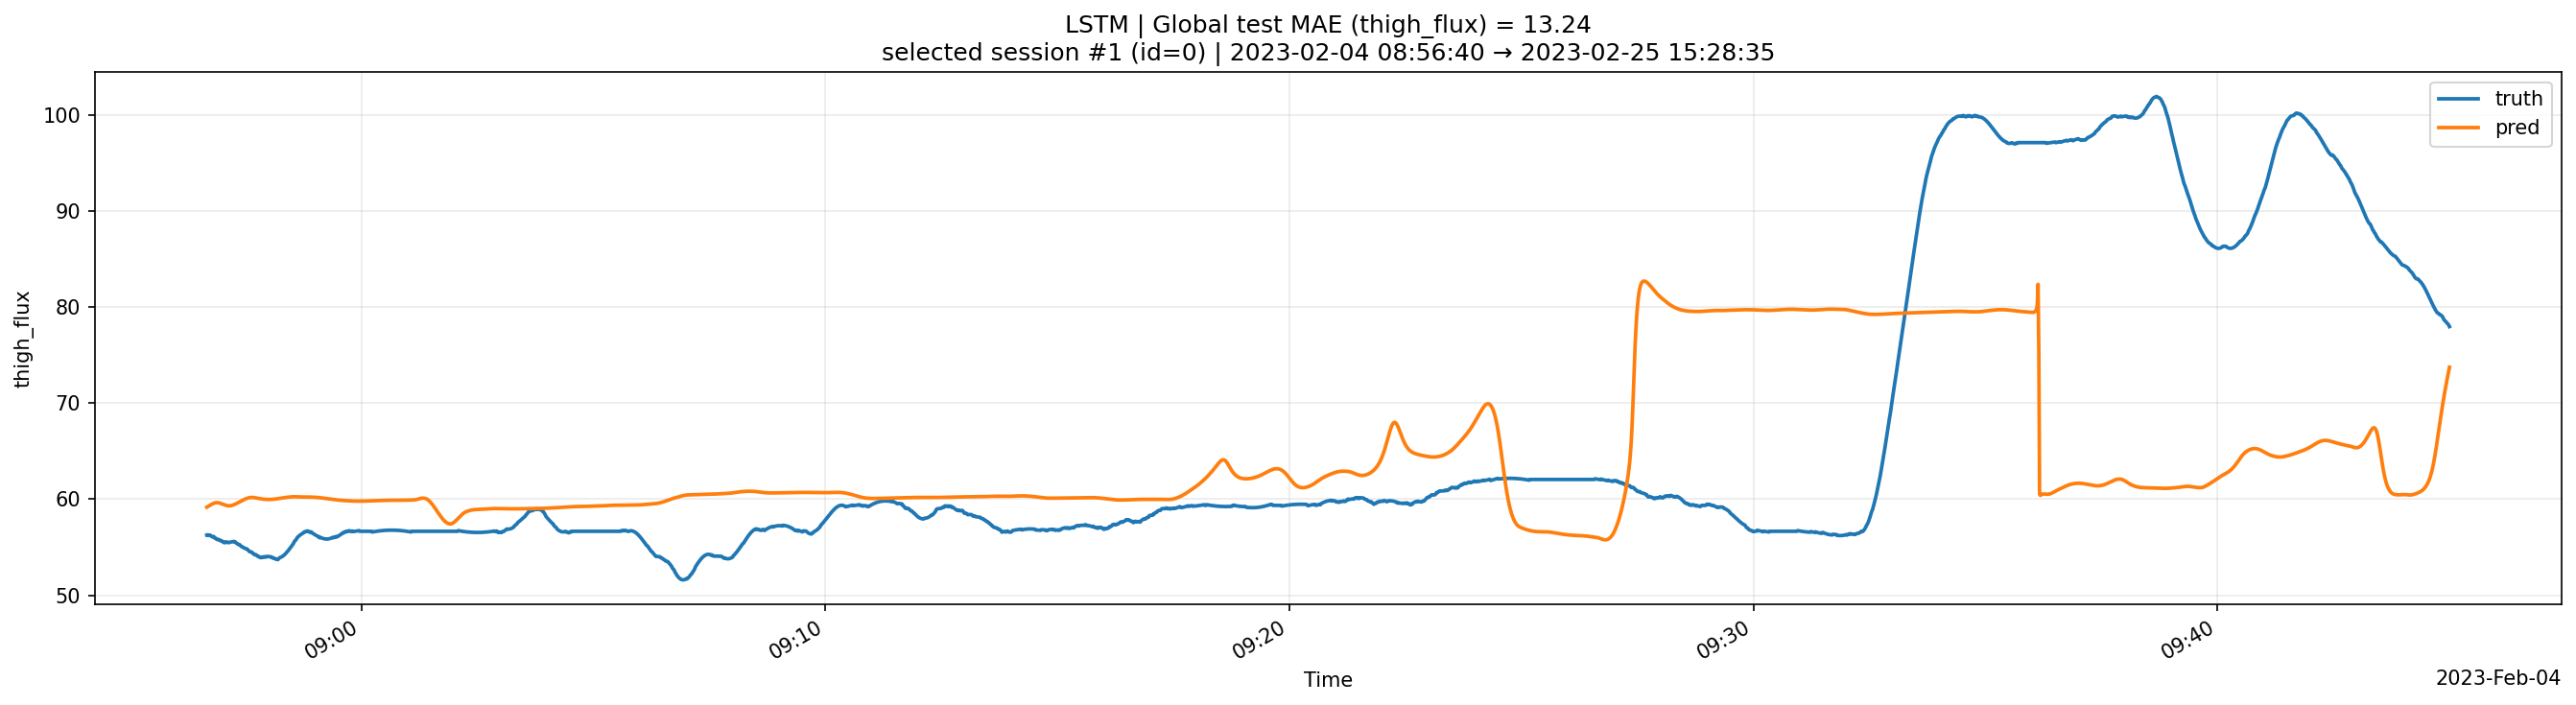

In [134]:
pred_df_test = predict_and_plot(
    model=model,
    X_test=X_test_scaled,
    y_test=y_test,
    participant_id="F7",
    mode="selected",
    session_number=1,
    gap_minutes=60,
    compress_gaps=True,
    window=window,
    target="thigh_flux",
    title="LSTM",
    device=device
)

# Result with historical features using the loaded model

In [148]:
bundle = load_lstm_bundle(
    "/content/drive/MyDrive/best_lstm_bundle_lstm_vFE.pth",
    LSTMRegressorClass=LSTMRegressor,
)

X_test_FE_scaled, X_test_FE_aligned = align_and_scale_X_test(
    X_test_FE,
    num_cols=bundle["num_cols"],
    scaler=bundle["scaler"],
)

model  = bundle["model"]
device = bundle["device"]
window = bundle["window"]
num_cols = bundle["num_cols"]

Loaded model from bundle.
window = 40 | hidden_dim = 64 | n_features = 210


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


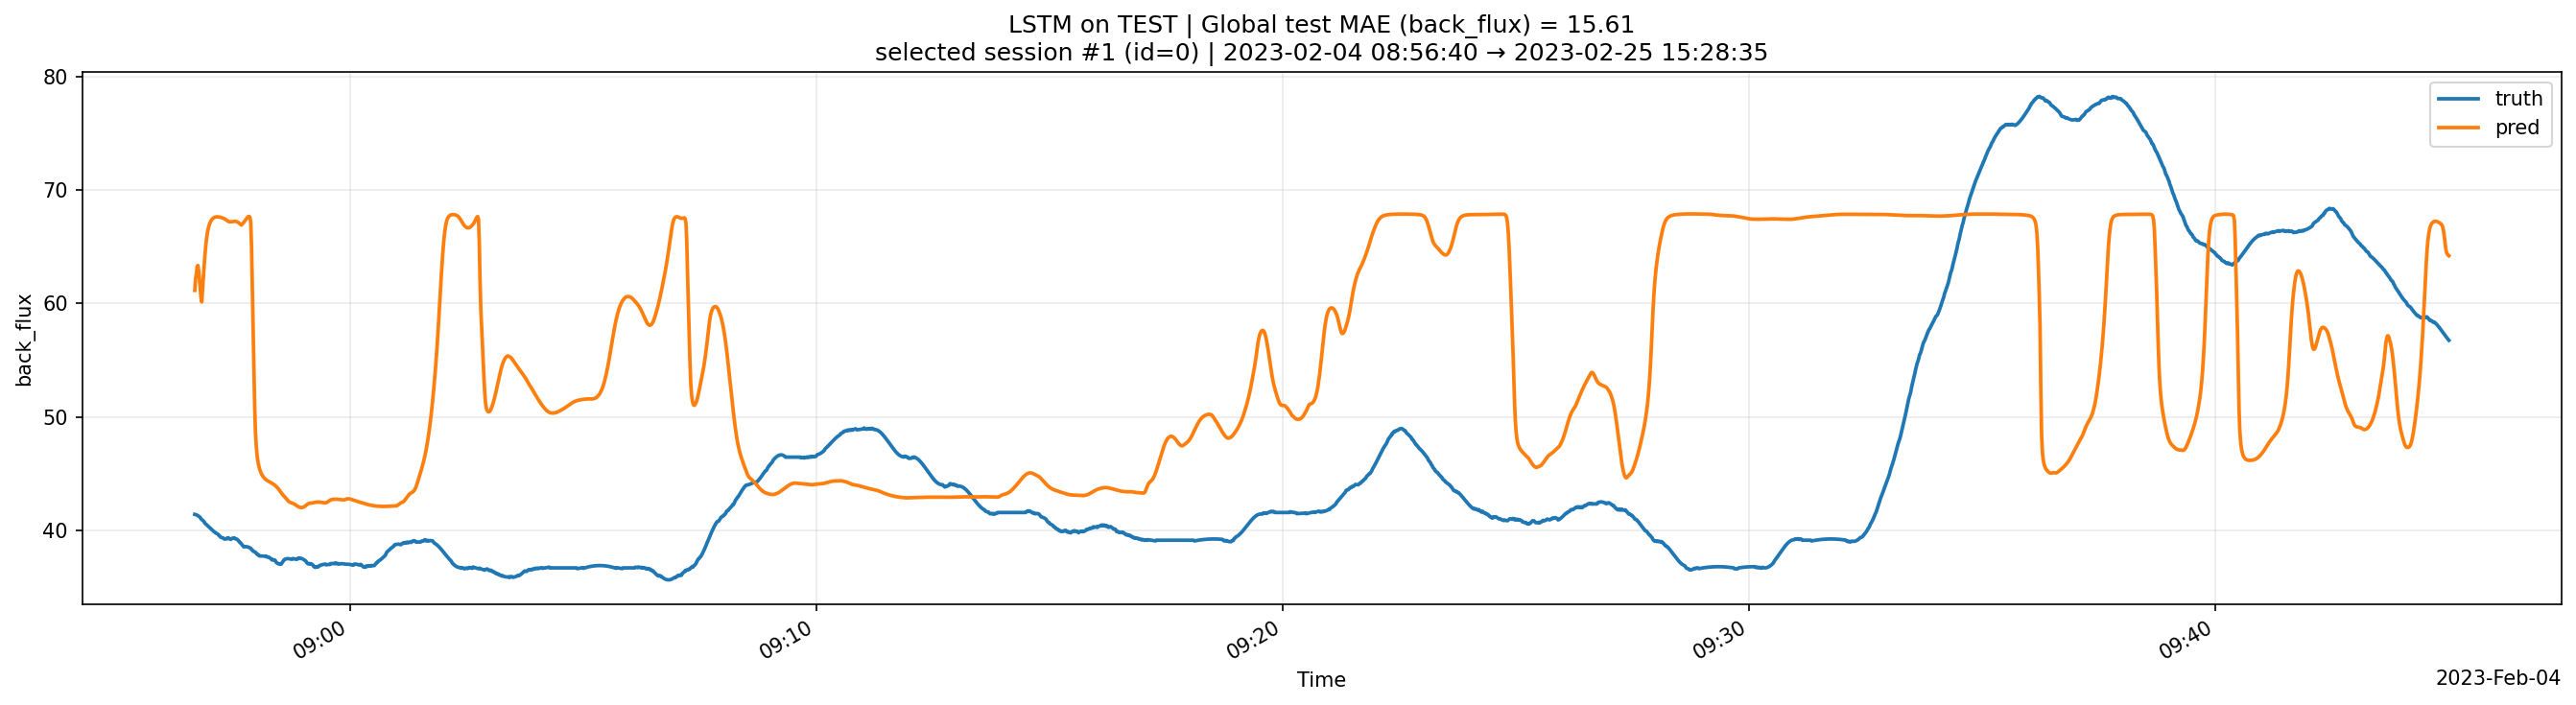

In [149]:
pred_df_test = predict_and_plot(
    model=model,
    X_test=X_test_FE_scaled,
    y_test=y_test_FE,
    participant_id="F7",
    mode="selected",
    session_number=1,
    gap_minutes=60,
    compress_gaps=True,
    window=window,
    target="back_flux",
    title="LSTM on TEST",
    device=device
)

In [150]:
pred_df_test = predict_and_plot(
    model=model,
    X_test_FE=X_test_FE_scaled,
    y_test_FE=y_test_FE,
    participant_id="F7",
    mode="selected",
    session_number=1,
    gap_minutes=60,
    compress_gaps=True,
    window=window,
    target="thigh_flux",
    title="LSTM",
    device=device
)

TypeError: predict_and_plot() got an unexpected keyword argument 'X_test_FE'

# **Training details**

## Training loop

For each fold and hyperparameter set, we:
1) fit a StandardScaler on the **training fold only** and apply it to train/val,  
2) train the LSTM with MAE loss and gradient clipping  
3) apply early stopping on validation MAE and keep the best model state for that fold.


In [ ]:
fold_results = []
grid_results = []

test_df = data_test.copy()

param_grid = {
    "window": [10, 20, 40, 60],
    "hidden_dim": [64, 128, 256],
    "lr": [1e-3, 1e-4, 3e-4, 1e-5],
}

## Hyperparameter search

We grid-search over:
- `window`: sequence length (temporal context),
- `hidden_dim`: LSTM capacity,
- `lr`: learning rate.

We select the configuration with the lowest mean validation MAE across folds.

In [ ]:
for window, hidden_dim, lr in product(param_grid["window"], param_grid["hidden_dim"], param_grid["lr"]):
    print(f"\n=== GRID CONFIG | window={window}, hidden_dim={hidden_dim}, lr={lr} ===")

    fold_results = []

    for fold, (tr_idx, va_idx) in enumerate(gkf.split(data_training, groups=groups), 1):
        train_df = data_training.iloc[tr_idx].copy()
        val_df = data_training.iloc[va_idx].copy()

        assert set(train_df["participant_id"]).isdisjoint(set(val_df["participant_id"]))

        drop_cols = target_cols + ["day", "room_temp_C"]
        X_train = train_df.drop(columns=drop_cols)
        X_val = val_df.drop(columns=drop_cols)

        y_train = train_df[target_cols].copy()
        y_val = val_df[target_cols].copy()

        id_cols = ["participant_id", "Time", "Session"]
        num_cols = [c for c in X_train.columns if c not in id_cols]

        x_scaler = StandardScaler()
        x_scaler.fit(X_train[num_cols])

        X_train_scaled = X_train.copy()
        X_val_scaled = X_val.copy()
        X_train_scaled[num_cols] = x_scaler.transform(X_train[num_cols])
        X_val_scaled[num_cols] = x_scaler.transform(X_val[num_cols])

        input_dim = len(num_cols)
        output_dim = len(target_cols)

        train_dataset = LSTMDataset(X_train_scaled, y_train, target_cols, window=window)
        val_dataset = LSTMDataset(X_val_scaled, y_val, target_cols, window=window)

        num_workers = 2
        pin_memory = (device.type == "cuda")
        persistent_workers = (num_workers > 0)

        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=pin_memory,
            persistent_workers=persistent_workers
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=pin_memory,
            persistent_workers=persistent_workers
        )

        model = LSTMRegressor(
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            fc_dim=8,
            output_dim=output_dim
        ).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.5, patience=4
        )

        use_amp = (device.type == "cuda")
        scaler_amp = torch.amp.GradScaler(enabled=use_amp)

        best_val = float("inf")
        best_state = None
        patience = 6
        bad_epochs = 0
        min_delta = 0.0
        n_epochs = 20

        best_mae_back, best_mae_thigh = None, None

        for epoch in range(n_epochs):
            # TRAIN
            model.train()
            train_abs_sum, n_train_elems = 0.0, 0

            for xb, yb in train_loader:
                xb = xb.to(device, non_blocking=True)
                yb = yb.to(device, non_blocking=True)

                optimizer.zero_grad(set_to_none=True)

                amp_device = "cuda" if use_amp else "cpu"
                with torch.amp.autocast(amp_device, enabled=use_amp):
                    preds = model(xb)
                    abs_err = (preds - yb).abs()
                    loss = abs_err.mean()

                scaler_amp.scale(loss).backward()
                scaler_amp.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler_amp.step(optimizer)
                scaler_amp.update()

                train_abs_sum += abs_err.sum().item()
                n_train_elems += abs_err.numel()

            train_loss = train_abs_sum / max(n_train_elems, 1)

            # VAL
            model.eval()
            val_abs_sum_total, n_val_elems = 0.0, 0
            val_abs_sum = torch.zeros(2, device=device)
            n_val_samples = 0

            with torch.no_grad():
                for xb, yb in val_loader:
                    xb = xb.to(device, non_blocking=True)
                    yb = yb.to(device, non_blocking=True)

                    amp_device = "cuda" if use_amp else "cpu"
                    with torch.amp.autocast(amp_device, enabled=use_amp):
                        preds = model(xb)
                        abs_err = (preds - yb).abs()

                    val_abs_sum += abs_err.sum(dim=0)
                    val_abs_sum_total += abs_err.sum().item()
                    n_val_elems += abs_err.numel()
                    n_val_samples += yb.size(0)

            val_loss = val_abs_sum_total / max(n_val_elems, 1)

            if epoch == 0:
                min_delta = 1e-3 * val_loss

            val_mae = (val_abs_sum / max(n_val_samples, 1)).detach().cpu().numpy()
            val_mae_back, val_mae_thigh = float(val_mae[0]), float(val_mae[1])

            scheduler.step(val_loss)

            if val_loss < best_val - min_delta:
                best_val = val_loss
                best_state = copy.deepcopy(model.state_dict())
                best_mae_back, best_mae_thigh = val_mae_back, val_mae_thigh
                bad_epochs = 0
            else:
                bad_epochs += 1

            if bad_epochs >= patience:
                print(f"Fold {fold} Early stopping (best val_loss={best_val:.4f})")
                break

            print(
                f"Fold {fold} | Epoch {epoch+1}/{n_epochs} "
                f"- train_loss: {train_loss:.4f} "
                f"- val_loss: {val_loss:.4f} "
                f"- val_mae_back: {val_mae_back:.2f} "
                f"- val_mae_thigh: {val_mae_thigh:.2f} "
                f"- lr: {optimizer.param_groups[0]['lr']:.1e}"
            )

        if best_state is not None:
            model.load_state_dict(best_state)

        fold_results.append({
            "fold": fold,
            "best_val_loss": float(best_val),
            "val_mae_back": float(best_mae_back) if best_mae_back is not None else float(val_mae_back),
            "val_mae_thigh": float(best_mae_thigh) if best_mae_thigh is not None else float(val_mae_thigh),
        })

        print("Fold done:", fold_results[-1])

    vals = [r["best_val_loss"] for r in fold_results]
    mean_val = float(np.mean(vals))
    std_val = float(np.std(vals))

    grid_results.append({
        "window": window,
        "hidden_dim": hidden_dim,
        "lr": lr,
        "mean_val_loss": mean_val,
        "std_val_loss": std_val,
    })

    print(f"GRID RESULT | mean={mean_val:.4f} | std={std_val:.4f}")


## Final training and checkpoint

After selecting the best hyperparameters, we create a final train/validation split **by participant** (80/20).  
We train once more on this split and save the best checkpoint to Drive, along with a lightweight bundle
(model weights + scaler stats + feature list) for reproducible inference.


In [ ]:
#  FINAL TRAIN
num_workers = 2
pin_memory = (device.type == "cuda")
persistent_workers = (num_workers > 0)

grid_df = pd.DataFrame(grid_results)
grid_df = grid_df.sort_values(
    by=["mean_val_loss", "std_val_loss"],
    ascending=[True, True]
)

best = grid_df.iloc[0]
best_window = int(best["window"])
best_hidden_dim = int(best["hidden_dim"])
best_lr = float(best["lr"])

print("BEST HP:", best_window, best_hidden_dim, best_lr)

rng = np.random.RandomState(42)
all_pids = np.array(sorted(data_training["participant_id"].unique()))
rng.shuffle(all_pids)

val_ratio = 0.2
n_val = max(1, int(len(all_pids) * val_ratio))
final_val_ids = set(all_pids[:n_val])
final_train_ids = set(all_pids[n_val:])

final_train_df = data_training[data_training["participant_id"].isin(final_train_ids)].copy()
final_val_df = data_training[data_training["participant_id"].isin(final_val_ids)].copy()

assert set(final_train_df["participant_id"]).isdisjoint(set(final_val_df["participant_id"]))

drop_cols = target_cols + ["day", "room_temp_C"]
id_cols = ["participant_id", "Time", "Session"]

X_train = final_train_df.drop(columns=drop_cols)
X_val = final_val_df.drop(columns=drop_cols)
X_test = test_df.drop(columns=drop_cols)

y_train = final_train_df[target_cols].copy()
y_val = final_val_df[target_cols].copy()
y_test = test_df[target_cols].copy()

num_cols = [c for c in X_train.columns if c not in id_cols]

x_scaler = StandardScaler()
x_scaler.fit(X_train[num_cols])

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = x_scaler.transform(X_train[num_cols])
X_val_scaled[num_cols] = x_scaler.transform(X_val[num_cols])
X_test_scaled[num_cols] = x_scaler.transform(X_test[num_cols])

input_dim = len(num_cols)
output_dim = len(target_cols)
window = best_window

final_train_dataset = LSTMDataset(X_train_scaled, y_train, target_cols, window=window)
final_val_dataset = LSTMDataset(X_val_scaled, y_val, target_cols, window=window)

final_train_loader = DataLoader(
    final_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers
)

final_val_loader = DataLoader(
    final_val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers
)

final_model = LSTMRegressor(
    input_dim=input_dim,
    hidden_dim=best_hidden_dim,
    fc_dim=8,
    output_dim=output_dim
).to(device)

final_optimizer = torch.optim.Adam(final_model.parameters(), lr=best_lr, weight_decay=1e-4)
final_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    final_optimizer, mode="min", factor=0.5, patience=3
)

use_amp = (device.type == "cuda")
amp_device = "cuda" if use_amp else "cpu"
final_scaler_amp = torch.amp.GradScaler(enabled=use_amp)

best_val = float("inf")
bad_epochs = 0
min_delta = 0.0
n_epochs = 60
patience = 8

FINAL_CKPT_PATH = "/content/drive/MyDrive/best_lstm_FINALv2.pt"

for epoch in range(n_epochs):
    # TRAIN
    final_model.train()
    train_abs_sum, n_train_elems = 0.0, 0

    for xb, yb in final_train_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        final_optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(amp_device, enabled=use_amp):
            preds = final_model(xb)
            abs_err = (preds - yb).abs()
            loss = abs_err.mean()

        final_scaler_amp.scale(loss).backward()
        final_scaler_amp.unscale_(final_optimizer)
        torch.nn.utils.clip_grad_norm_(final_model.parameters(), 1.0)
        final_scaler_amp.step(final_optimizer)
        final_scaler_amp.update()

        train_abs_sum += abs_err.sum().item()
        n_train_elems += abs_err.numel()

    train_loss = train_abs_sum / max(n_train_elems, 1)

    # VAL
    final_model.eval()
    val_abs_sum_total, n_val_elems = 0.0, 0

    with torch.no_grad():
        for xb, yb in final_val_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            with torch.amp.autocast(amp_device, enabled=use_amp):
                preds = final_model(xb)
                abs_err = (preds - yb).abs()

            val_abs_sum_total += abs_err.sum().item()
            n_val_elems += abs_err.numel()

    val_loss = val_abs_sum_total / max(n_val_elems, 1)

    if epoch == 0:
        min_delta = 1e-3 * val_loss

    final_scheduler.step(val_loss)

    # Early stopping + save
    if val_loss < best_val - min_delta:
        best_val = val_loss
        bad_epochs = 0
        torch.save(final_model.state_dict(), FINAL_CKPT_PATH)
    else:
        bad_epochs += 1

    if bad_epochs >= patience:
        print(f"FINAL Early stopping (best val_loss={best_val:.4f})")
        break

    print(
        f"FINAL | Epoch {epoch+1}/{n_epochs} "
        f"- train_loss: {train_loss:.4f} "
        f"- val_loss: {val_loss:.4f} "
        f"- lr: {final_optimizer.param_groups[0]['lr']:.1e}"
    )

MODEL_NAME = "lstm"
MODEL_VERSION = "vFINALv3"

BEST_WEIGHTS_PATH = f"/content/drive/MyDrive/best_lstm_{MODEL_NAME}_{MODEL_VERSION}.pt"
BEST_BUNDLE_PATH = f"/content/drive/MyDrive/best_lstm_bundle_{MODEL_NAME}_{MODEL_VERSION}.pth"

torch.save(torch.load(FINAL_CKPT_PATH, map_location="cpu"), BEST_WEIGHTS_PATH)

torch.save({
    "model_state_dict": torch.load(FINAL_CKPT_PATH, map_location="cpu"),
    "input_dim": input_dim,
    "hidden_dim": best_hidden_dim,
    "fc_dim": 8,
    "output_dim": 2,
    "num_cols": list(num_cols),
    "window": best_window,
    "scaler_mean": x_scaler.mean_.tolist(),
    "scaler_scale": x_scaler.scale_.tolist(),
    "final_val_loss": float(best_val),
}, BEST_BUNDLE_PATH)

print("Saved FINAL weights to:", BEST_WEIGHTS_PATH)
print("Saved FINAL bundle to:", BEST_BUNDLE_PATH)

# **Training details with historical features**

In [ ]:
# Separatin des participants pour éviter data leakage
groups = data_training_FE["participant_id"].values
gkf = GroupKFold(n_splits=5)

In [ ]:
# FINAL TRAIN
num_workers = 2
pin_memory = (device.type == "cuda")
persistent_workers = (num_workers > 0)

grid_df = pd.DataFrame(grid_results)
grid_df = grid_df.sort_values(
    by=["mean_val_loss", "std_val_loss"],
    ascending=[True, True]
)

best = grid_df.iloc[0]
best_window = int(best["window"])
best_hidden_dim = int(best["hidden_dim"])
best_lr = float(best["lr"])
print("BEST HP:", best_window, best_hidden_dim, best_lr)


# 1) Split final Train/Val PAR participant (avec le nouveau nom de dataset)
rng = np.random.RandomState(42)
all_pids = np.array(sorted(data_training_FE["participant_id"].unique()))
rng.shuffle(all_pids)

val_ratio = 0.2
n_val = max(1, int(len(all_pids) * val_ratio))
final_val_ids = set(all_pids[:n_val])
final_train_ids = set(all_pids[n_val:])

final_train_df = data_training_FE[data_training_FE["participant_id"].isin(final_train_ids)].copy()
final_val_df   = data_training_FE[data_training_FE["participant_id"].isin(final_val_ids)].copy()
assert set(final_train_df["participant_id"]).isdisjoint(set(final_val_df["participant_id"]))

# Test df (nouveau nom)
test_df = data_test_FE.copy()

# 2) Features/targets (mêmes colonnes que CV)
drop_cols = target_cols_FE + ["day", "room_temp_C"]
id_cols = ["participant_id", "Time", "Session"]

X_train = final_train_df.drop(columns=drop_cols)
X_val   = final_val_df.drop(columns=drop_cols)
X_test  = test_df.drop(columns=drop_cols)

y_train = final_train_df[target_cols_FE].copy()
y_val   = final_val_df[target_cols_FE].copy()
y_test  = test_df[target_cols_FE].copy()

num_cols = [c for c in X_train.columns if c not in id_cols]

# 3) Scaler fit UNIQUEMENT sur final_train
x_scaler = StandardScaler()
x_scaler.fit(X_train[num_cols])

X_train_scaled = X_train.copy()
X_val_scaled   = X_val.copy()
X_test_scaled  = X_test.copy()

X_train_scaled[num_cols] = x_scaler.transform(X_train[num_cols])
X_val_scaled[num_cols]   = x_scaler.transform(X_val[num_cols])
X_test_scaled[num_cols]  = x_scaler.transform(X_test[num_cols])

input_dim = len(num_cols)
output_dim = len(target_cols_FE)

# 4) Datasets/loaders (mêmes réglages + mêmes meilleurs paramètres)
window = best_window
final_train_dataset = LSTMDataset(X_train_scaled, y_train, target_cols_FE, window=window)
final_val_dataset   = LSTMDataset(X_val_scaled,   y_val,   target_cols_FE, window=window)

final_train_loader = DataLoader(
    final_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers
)

final_val_loader = DataLoader(
    final_val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
    persistent_workers=persistent_workers
)

# 5) Modèle final + train (exactement comme dans les folds)
final_model = LSTMRegressor(input_dim=input_dim, hidden_dim=best_hidden_dim, fc_dim=8, output_dim=output_dim).to(device)
final_optimizer = torch.optim.Adam(final_model.parameters(), lr=best_lr, weight_decay=1e-4)
final_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(final_optimizer, mode="min", factor=0.5, patience=3)

use_amp = (device.type == "cuda")
amp_device = "cuda" if use_amp else "cpu"
final_scaler_amp = torch.amp.GradScaler(enabled=use_amp)

best_val = float("inf")
bad_epochs = 0
min_delta = 0.0
n_epochs = 60
patience = 8
FINAL_CKPT_PATH = "/content/drive/MyDrive/best_lstm_FINALvFE.pt"

for epoch in range(n_epochs):
    # TRAIN
    final_model.train()
    train_abs_sum, n_train_elems = 0.0, 0

    for xb, yb in final_train_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        final_optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(amp_device, enabled=use_amp):
            preds = final_model(xb)
            abs_err = (preds - yb).abs()
            loss = abs_err.mean()

        final_scaler_amp.scale(loss).backward()
        final_scaler_amp.unscale_(final_optimizer)
        torch.nn.utils.clip_grad_norm_(final_model.parameters(), 1.0)
        final_scaler_amp.step(final_optimizer)
        final_scaler_amp.update()

        train_abs_sum += abs_err.sum().item()
        n_train_elems += abs_err.numel()

    train_loss = train_abs_sum / max(n_train_elems, 1)  # MAE globale

    # VAL
    final_model.eval()
    val_abs_sum_total, n_val_elems = 0.0, 0

    with torch.no_grad():
        for xb, yb in final_val_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            with torch.amp.autocast(amp_device, enabled=use_amp):
                preds = final_model(xb)
                abs_err = (preds - yb).abs()

            val_abs_sum_total += abs_err.sum().item()
            n_val_elems += abs_err.numel()

    val_loss = val_abs_sum_total / max(n_val_elems, 1)  # MAE globale

    if epoch == 0:
        min_delta = 1e-3 * val_loss

    final_scheduler.step(val_loss)

    # Early stopping + save
    if val_loss < best_val - min_delta:
        best_val = val_loss
        bad_epochs = 0
        torch.save(final_model.state_dict(), FINAL_CKPT_PATH)
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print(f"FINAL Early stopping (best val_loss={best_val:.4f})")
            break

    print(
        f"FINAL | Epoch {epoch+1}/{n_epochs} "
        f"- train_loss: {train_loss:.4f} "
        f"- val_loss: {val_loss:.4f} "
        f"- lr: {final_optimizer.param_groups[0]['lr']:.1e}"
    )

# 6) Bundle FINAL (cohérent, sans “best fold”)
MODEL_NAME = "lstm"
MODEL_VERSION = "vFE"

BEST_WEIGHTS_PATH = f"/content/drive/MyDrive/best_lstm_{MODEL_NAME}_{MODEL_VERSION}.pt"
BEST_BUNDLE_PATH  = f"/content/drive/MyDrive/best_lstm_bundle_{MODEL_NAME}_{MODEL_VERSION}.pth"

torch.save(torch.load(FINAL_CKPT_PATH, map_location="cpu"), BEST_WEIGHTS_PATH)

torch.save({
    "model_state_dict": torch.load(FINAL_CKPT_PATH, map_location="cpu"),
    "input_dim": input_dim,
    "hidden_dim": best_hidden_dim,
    "fc_dim": 8,
    "output_dim": output_dim,
    "num_cols": list(num_cols),
    "window": best_window,
    "scaler_mean": x_scaler.mean_.tolist(),
    "scaler_scale": x_scaler.scale_.tolist(),
    "final_val_loss": float(best_val),
}, BEST_BUNDLE_PATH)

print("Saved FINAL weights to:", BEST_WEIGHTS_PATH)
print("Saved FINAL bundle to:", BEST_BUNDLE_PATH)


BEST HP: 40 64 0.0001
FINAL | Epoch 1/60 - train_loss: 61.7831 - val_loss: 58.1260 - lr: 1.0e-04
FINAL | Epoch 2/60 - train_loss: 54.7131 - val_loss: 49.3390 - lr: 1.0e-04
FINAL | Epoch 3/60 - train_loss: 44.6565 - val_loss: 37.6446 - lr: 1.0e-04
FINAL | Epoch 4/60 - train_loss: 32.4787 - val_loss: 26.2165 - lr: 1.0e-04
FINAL | Epoch 5/60 - train_loss: 22.1284 - val_loss: 17.8054 - lr: 1.0e-04
FINAL | Epoch 6/60 - train_loss: 15.0118 - val_loss: 14.0254 - lr: 1.0e-04
FINAL | Epoch 7/60 - train_loss: 10.2138 - val_loss: 13.4804 - lr: 1.0e-04
FINAL | Epoch 8/60 - train_loss: 8.5471 - val_loss: 12.4343 - lr: 1.0e-04
FINAL | Epoch 9/60 - train_loss: 7.9251 - val_loss: 13.4606 - lr: 1.0e-04
FINAL | Epoch 10/60 - train_loss: 7.5044 - val_loss: 14.0400 - lr: 1.0e-04
FINAL | Epoch 11/60 - train_loss: 7.2440 - val_loss: 13.4387 - lr: 1.0e-04
FINAL | Epoch 12/60 - train_loss: 7.0318 - val_loss: 13.4053 - lr: 5.0e-05
FINAL | Epoch 13/60 - train_loss: 6.7909 - val_loss: 13.3213 - lr: 5.0e-05
FINAL